Here, we branch out from the path-splitting tracer to implement the optimal polygonal path algorithm and the rest of the potrace optimization algorithms.

In [1]:
import numpy as np
from skimage.segmentation import flood_fill
import matplotlib.pyplot as plt
import math

In [2]:
# Define various constructs
class _Point:
    def __init__(self, x: float = 0, y: float = 0):
        self.x = x
        self.y = y

    def __repr__(self):
        return "Pt(%f, %f)" % (self.x, self.y)

class _Path:
    def __init__(self, pt: list, region_in: int, region_out: int):
        self.pt = pt
        self.region_in, self.region_out = region_in, region_out
        self.cyclic = False
        self.twinpath = None

        self._lon = []  # lon[len]: (i,lon[i]) = longest straight line from i
        self._x0 = 0  # /* origin for sums */
        self._y0 = 0  # /* origin for sums */
        self._sums = []  # / *sums[len + 1]: cache for fast summing * /

        self._m = 0  # /* length of optimal polygon */
        self._po = []  # /* po[m]: optimal polygon */
        self._curve = []  # /* curve[m]: array of curve elements */
        self._ocurve = []  # /* ocurve[om]: array of curve elements */
        self._fcurve = []  # /* final curve: this points to either curve or ocurve.*/

    def __len__(self):
        return len(self.pt)

class _Sums:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.x2 = 0
        self.xy = 0
        self.y2 = 0

class _Segment: # List of 3 points, with corner type tage and Bezier parameter values
    def __init__(self):
        self.tag = 0
        self.c = [_Point(), _Point(), _Point()]
        self.vertex = _Point()
        self.alpha = 0.0
        self.alpha0 = 0.0
        self.beta = 0.0

class _Curve: # Collection of segments for a given polygon which make it up
    def __init__(self, m):
        self.segments = [_Segment() for _ in range(m)]
        self.alphacurve = False

    def __len__(self):
        return len(self.segments)

    @property
    def n(self):
        return len(self)

    def __getitem__(self, item):
        return self.segments[item]


In [3]:
def randArray(nrows: int, ncols: int, nsegments: int) -> np.ndarray:
    return np.random.randint(0, nsegments, (nrows, ncols))

def floodFill(S: np.ndarray, i: int, j: int, c:int) -> np.ndarray:
    flood_fill(S, (i, j), c, connectivity=1, in_place=True)
    return S

def renumberContiguousSegment(S: np.array) -> np.ndarray:
    c = -1
    for i, j in np.ndindex(S.shape):
        if S[i, j] >= 0:
            floodFill(S, i, j, c)
            c -= 1
    S = -(S + 1)
    ns = -c - 1
    return S, ns

def init_segmentation(nrows, ncols, nsegments = 2, scale_factor = 3): # Initiates in a particular way right now
    segmentation = randArray(nrows, ncols, nsegments)
    for i in range(9):
        segmentation[1, i] = 2
        segmentation[9, i] = 2
        segmentation[i + 1, 0] = 2
        segmentation[i + 1, 8] = 2
    segmentation, nsegments = renumberContiguousSegment(segmentation)
    # Scale up by scale factor
    block = np.ones((scale_factor, scale_factor), dtype=segmentation.dtype)
    segmentation = np.kron(segmentation, block)
    nrows *= scale_factor
    ncols *= scale_factor
    return segmentation, nsegments, nrows, ncols

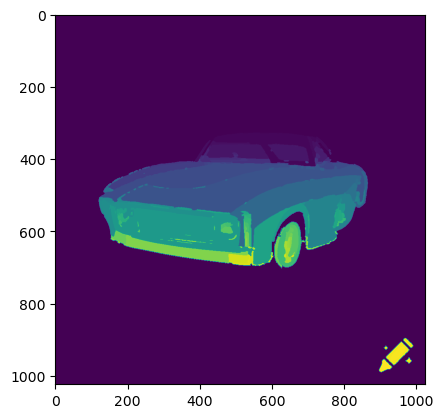

In [4]:
# CALC - Initalize segmentation
if False:
    nrows = 20
    ncols = nrows
    scalefactor = 5
    segmentation, nsegments, nrows, ncols = init_segmentation(nrows, ncols, scale_factor=scalefactor)

    plt.imshow(segmentation)
else:
    segmentation = np.load('segmentation.npy')
    plt.imshow(segmentation)
    nsegments = np.max(segmentation) + 1
    nrows, ncols = segmentation.shape


**Problem 1 - Assume we have a numpy array that is nrows x ncols, with nsegments number of segments that are connected, labeled 0 to nsegments - 1. We want to get the path around each segment's boundary, as well as see which regions neighbor one another and which are contained in one another.**

In [5]:
# Helper functions to trace a region and get a path/paths
def pad_seg(segmentation: np.ndarray) -> np.ndarray:
    """Pad the segmentation array to get the aray of corner values, 
    where the value stored is the pixel with the given vertex at the top left corner (-1 if not in image)"""
    seg_padded = np.vstack([segmentation, -1 * np.ones((1, segmentation.shape[1]))])
    seg_padded = np.hstack([seg_padded, -1 * np.ones((seg_padded.shape[0], 1))])
    return seg_padded.astype(int)

def find_corner(segmentation: np.array, region: int) -> _Point:
    """Find the upper left corner of the segment with a given number"""
    for x in range(nrows):
        for y in range(ncols):
            if segmentation[x, y] == region:
                return _Point(x, y)

def compute_corners(seg: np.ndarray, nsegments: int) -> np.ndarray:
    """Compute upper left corner of all paths at once, store for later use"""
    upper_left_corners = np.zeros((nsegments, 2), dtype = int)
    found_yet = np.zeros(nsegments, dtype = int)
    for x in range(nrows):
        for y in range(ncols):
            cur_region = int(seg[x, y])
            if cur_region != -1:
                if found_yet[cur_region] == 0:
                  upper_left_corners[cur_region, 0], upper_left_corners[cur_region, 1] = x, y
                  found_yet[cur_region] = 1
    return upper_left_corners

def left_pix(x, y, dirx, diry, seg, rows, cols) -> int:
    """Compute segment of the next left pixel at a given vertex going in a given direction"""
    if dirx == 1:
      if x >= 0 and x < rows and y >= 0 and y < cols:
        return seg[x, y]
      return -1
    if dirx == -1:
      if x >= 1 and x < rows + 1 and y >= 1 and y < cols + 1:
        return seg[x - 1, y - 1]
      return -1
    if diry == 1:
      if x >= 1 and x < rows + 1 and y >= 0 and y < cols:
        return seg[x - 1, y]
      return -1
    if diry == -1:
      if x >= 0 and x < rows and y >= 1 and y < cols + 1:
        return segmentation[x, y - 1]
    return -1

def right_pix(x, y, dirx, diry, seg, rows, cols) -> int:
    if dirx == 1:
      if x >= 0 and x < rows and y - 1 >= 0 and y - 1 < cols:
        return seg[x, y - 1]
      return -1
    if dirx == -1:
      if x - 1 >= 0 and x - 1 < rows and y >= 0 and y < cols:
        return seg[x - 1, y]
      return -1
    if diry == 1:
      if x >= 0 and x < rows and y >= 0 and y < cols:
        return seg[x, y]
      return -1
    if diry == -1:
      if x - 1 >= 0 and x - 1 < rows and y - 1 >= 0 and y - 1 < cols:
        return seg[x - 1, y - 1]
    return -1

def find_path(seg: np.ndarray, x0: int, y0: int, region: int, graph: np.ndarray):
    """Get the boundary points and the outside regions for a given region number; x0, y0 are the upper lefthand corner"""
    x = x0
    y = y0
    rows, cols = seg.shape

    # Starting directions are known because we are at the upper left corner; note that positive x is down, positive y is right
    dirx = 1
    diry = 0
    # Start with an empty list of points on the path
    pt = []

    while True:
        # Look at the current pixel to the right
        right_pixel = right_pix(x, y, dirx, diry, seg, rows, cols)
        if right_pixel != -1:
          graph[region, right_pixel] = 1
        
        # Add point to path
        pt.append((_Point(int(x), int(y)), right_pixel))

        # Move to the next point
        x += dirx
        y += diry

        # Check if path complete - used to be after moving to next point - Note that this can mess up contiguousness of last and first, FIX
        if x == x0 and y == y0:
            break

         # Compute the next left and right pixels from the current position to decide if direction change necessary
        left_pixel = left_pix(x, y, dirx, diry, seg, rows, cols)
        right_pixel = right_pix(x, y, dirx, diry, seg, rows, cols)

        # We want there to always be a region pixel on the left and not on the right
        if right_pixel == region and left_pixel != region:
            # Ambiguous turn, for now we turn right
            dirx, diry = diry, -dirx
        elif left_pixel == region and right_pixel == region:
            # Turn right
            dirx, diry = diry, -dirx
        elif left_pixel != region and right_pixel != region:
            # Turn left
            dirx, diry = -diry, dirx
        # Other case is when left_pixel == region and right_pixel != region, in which case we continue straight

    # Allocate new path object; Area may not be accurate, not sure
    return pt

def create_paths_from_pt_list(pt, region):
  """Takes a list of points and creates a list of paths from it, which overlap on the ends"""
  path_count = 0
  first_path = []

  path_list = []
  cur_pts = []
  region_out = pt[0][1]
  # Loop through point-region pairs
  for pair in pt:
    # If the outside region has changesd, cap the current path, add it, and increment the path count
    if pair[1] != region_out:
      cur_pts.append(pair[0])
      if path_count == 0:
         first_path = cur_pts
      else:
        path_list.append(_Path(cur_pts, region, region_out))
      region_out = pair[1]
      cur_pts = []
      path_count += 1
    cur_pts.append(pair[0])
  # We withold adding the first path -- now, we add the first and last paths, seeing if they must be combined
  if pt[0][1] == region_out:
    path_list.append(_Path(cur_pts + first_path, region, region_out))
  else:
    cur_pts.append(pt[0][0])
    path_list.append(_Path(cur_pts, region, region_out))
    path_list = [_Path(first_path, region, pt[0][1])] + path_list

  # If there is only one path, it is cyclic
  if len(path_list) == 1:
     path_list[0].cyclic = True
  return path_list

def print_pathpts(path: _Path):
  """Print all points on a path sequentially"""
  for point in path.pt:
      print(point.x, point.y)

def find_path_for_region(seg_vertices: np.ndarray, region: int, corner_arr: np.ndarray, graph: np.ndarray):
  """Given the pre-computed corner array, compute and return the path for a give region number"""
  corner_x, corner_y = corner_arr[region, 0], corner_arr[region, 1]
  pt = find_path(seg_vertices, corner_x, corner_y, region, graph)
  return create_paths_from_pt_list(pt, region)

# Function which gets all decomposed paths for a segmentation
def get_decomposed_paths(segmentation, nsegments):
    """Get list of decomposed paths for each region in a segmentation, as well as neighbor info"""
    graph = np.zeros((nsegments, nsegments), dtype = int) # Create a graph to track neighbor information
    seg_vertices = pad_seg(segmentation) # Pad the segmentation so that it represents uppere left vertices
    corners = compute_corners(seg_vertices, nsegments) # Compute the corners of each region
    plist = [] # Create a list which will store the decomposed path list for region i in its ith spot
    for i in range(nsegments):
        plist.append(find_path_for_region(seg_vertices, i, corners, graph))
    return plist, graph

In [6]:
# CALC - Graph tracks which components are inside which: graph[i, j] = 1 <-> region i has region j directly outside of it
plist, graph = get_decomposed_paths(segmentation, nsegments)

In [7]:
# Helper functions to show a given path and its constituent parts
def show_segmentation(segmentation):
    plt.imshow(segmentation)
    plt.show()

def display_path(path: _Path, sidelength = nrows + 1):
    """Display a given path in a grid with given sidelength"""
    path_arr = np.zeros((sidelength, sidelength))
    for point in path.pt:
        path_arr[point.x, point.y] = 1
    plt.imshow(path_arr)

def display_pathlist(pathlist, sidelength = nrows + 1):
    for path in pathlist:
        display_path(path, sidelength)
        plt.show()

In [8]:
# Show the segmentation and the path outline of a given path
# show_segmentation(segmentation)
# display_pathlist(plist[2])

In [9]:
# Graph operations
def search(graph: np.ndarray, node: int, visited=None):
    if visited is None:
        visited = set()
    visited.add(node)

    for neighbor in np.argwhere(graph[node, :] == 1):
        if neighbor[0] not in visited:
            search(graph, neighbor[0], visited)
    return visited

def get_graph_info(graph, nsegments):
    # Calculate which elements are immediate neighbors
    imm_neighbor = (graph & graph.T).astype(int)

    # Calculate groups of neighbors
    nbrs = [] # List of groups of neighbors
    processed = np.zeros(nsegments, dtype = int) # Tracks which segments have been assigned a group
    which_nbr = [None] * nsegments # Tracks which neighbor group a given region belongs to
    counter = 0
    for i in range(nsegments):
        if processed[i] == 0:
            nbr_set = search(imm_neighbor, i)
            nbrs.append(nbr_set)
            for j in nbr_set:
                processed[j] = 1
                which_nbr[j] = counter
                counter += 1

    # Calculate which regions directly contain which other regions; dir_contain[i, j] = 1 if region i is contained in region j and i touches j
    dir_contain = (graph & ~graph.T).astype(int)

    # Link together groups of neighbors by giving each neighbor group a parent which contains it directly; -1 means no parent
    nbr_parents = [-1] * counter
    for index in np.argwhere(dir_contain == 1):
        nbr_parents[which_nbr[index[0]]]  = which_nbr[index[1]]

    return imm_neighbor, nbrs, which_nbr, dir_contain, nbr_parents

In [10]:
# CALC - Extract meaningful information from the graph
immediate_nbrs, nbr_groups, which_nbr, dir_contain, nbr_parents = get_graph_info(graph, nsegments)

In [11]:
def get_unique_paths(plist, nsegments):
    unique_paths = []
    for region in range(nsegments):
        for path in plist[region]:
            if path.twinpath == None:
                unique_paths.append(path)
                region_out = path.region_out
                if region_out != -1 and immediate_nbrs[region, region_out]:
                    for path2 in plist[region_out]:
                        if path2.region_out == region:
                            if path2.pt[0].x == path.pt[-1].x and path2.pt[0].y == path.pt[-1].y:
                                if path2.pt[-1].x == path.pt[0].x and path2.pt[-1].y == path.pt[0].y:
                                    path2.twinpath = len(unique_paths) - 1
    return unique_paths

unique_paths = get_unique_paths(plist, nsegments)
# display_pathlist(unique_paths)

**Problem 2 - Calculate straight segments that make up each path, and find an optimal configuration of straight sgements for all paths that optimizes the given penalties and shares the same segments where regions neighbor one another.**

In [12]:
# Auxililary math functions
def sign(x):
    if x > 0:
        return 1
    if x < 0:
        return -1
    else:
        return 0

def mod(a: int, n: int) -> int:
    return a % n if a >= n else a if a >= 0 else n - 1 - (-1 - a) % n

def floordiv(a: int, n: int):
    return a // n if a >= 0 else -1 - (-1 - a) // n

def interval(t: float, a: _Point, b: _Point):
    return _Point(a.x + t * (b.x - a.x), a.y + t * (b.y - a.y))

def dorth_infty(p0: _Point, p2: _Point):
    """
    return a direction that is 90 degrees counterclockwise from p2-p0,
    but then restricted to one of the major wind directions (n, nw, w, etc)
    """
    return _Point(-sign(p2.y - p0.y), sign(p2.x - p0.x))

def dpara(p0: _Point, p1: _Point, p2: _Point) -> float:
    """
    /* return (p1-p0)x(p2-p0), the area of the parallelogram */
    """
    x1 = p1.x - p0.x
    y1 = p1.y - p0.y
    x2 = p2.x - p0.x
    y2 = p2.y - p0.y
    return x1 * y2 - x2 * y1

def ddenom(p0: _Point, p2: _Point) -> float:
    """
    ddenom/dpara have the property that the square of radius 1 centered
    at p1 intersects the line p0p2 iff |dpara(p0,p1,p2)| <= ddenom(p0,p2)
    """
    r = dorth_infty(p0, p2)
    return r.y * (p2.x - p0.x) - r.x * (p2.y - p0.y)

def cyclic(a: int, b: int, c: int) -> int:
    """
    /* return 1 if a <= b < c < a, in a cyclic sense (mod n) */
    """
    if a <= c:
        return a <= b < c
    else:
        return a <= b or b < c

def pointslope(pp: _Path, i: int, j: int, ctr: _Point, dir: _Point) -> None:
    """
    determine the center and slope of the line i..j. Assume i<j. Needs
    "sum" components of p to be set.
    """

    # /* assume i<j */

    n = len(pp)
    sums = pp._sums

    r = 0  # /* rotations from i to j */

    while j >= n:
        j -= n
        r += 1

    while i >= n:
        i -= n
        r -= 1

    while j < 0:
        j += n
        r -= 1

    while i < 0:
        i += n
        r += 1

    x = sums[j + 1].x - sums[i].x + r * sums[n].x
    y = sums[j + 1].y - sums[i].y + r * sums[n].y
    x2 = sums[j + 1].x2 - sums[i].x2 + r * sums[n].x2
    xy = sums[j + 1].xy - sums[i].xy + r * sums[n].xy
    y2 = sums[j + 1].y2 - sums[i].y2 + r * sums[n].y2
    k = j + 1 - i + r * n

    ctr.x = x / k
    ctr.y = y / k

    a = float(x2 - x * x / k) / k
    b = float(xy - x * y / k) / k
    c = float(y2 - y * y / k) / k

    lambda2 = (
        a + c + math.sqrt((a - c) * (a - c) + 4 * b * b)
    ) / 2  # /* larger e.value */

    # /* now find e.vector for lambda2 */
    a -= lambda2
    c -= lambda2

    if math.fabs(a) >= math.fabs(c):
        l = math.sqrt(a * a + b * b)
        if l != 0:
            dir.x = -b / l
            dir.y = a / l
    else:
        l = math.sqrt(c * c + b * b)
        if l != 0:
            dir.x = -c / l
            dir.y = b / l
    if l == 0:
        # sometimes this can happen when k=4:
        # the two eigenvalues coincide */
        dir.x = 0
        dir.y = 0

def quadform(Q: list, w: _Point) -> float:
    """Apply quadratic form Q to vector w = (w.x,w.y)"""
    v = (w.x, w.y, 1.0)
    sum = 0.0
    for i in range(3):
        for j in range(3):
            sum += v[i] * Q[i][j] * v[j]
    return sum

def xprod(p1x, p1y, p2x, p2y) -> float:
    """calculate p1 x p2"""
    return p1x * p2y - p1y * p2x

def cprod(p0: _Point, p1: _Point, p2: _Point, p3: _Point) -> float:
    """calculate (p1-p0)x(p3-p2)"""
    x1 = p1.x - p0.x
    y1 = p1.y - p0.y
    x2 = p3.x - p2.x
    y2 = p3.y - p2.y
    return x1 * y2 - x2 * y1

def iprod(p0: _Point, p1: _Point, p2: _Point) -> float:
    """calculate (p1-p0)*(p2-p0)"""
    x1 = p1.x - p0.x
    y1 = p1.y - p0.y
    x2 = p2.x - p0.x
    y2 = p2.y - p0.y
    return x1 * x2 + y1 * y2

def iprod1(p0: _Point, p1: _Point, p2: _Point, p3: _Point) -> float:
    """calculate (p1-p0)*(p3-p2)"""
    x1 = p1.x - p0.x
    y1 = p1.y - p0.y
    x2 = p3.x - p2.x
    y2 = p3.y - p2.y
    return x1 * x2 + y1 * y2

def sq(x: float) -> float:
    return x * x

def ddist(p: _Point, q: _Point) -> float:
    """calculate distance between two points"""
    return math.sqrt(sq(p.x - q.x) + sq(p.y - q.y))

def bezier(t: float, p0: _Point, p1: _Point, p2: _Point, p3: _Point) -> _Point:
    """calculate point of a bezier curve"""
    s = 1 - t

    """
    Note: a good optimizing compiler (such as gcc-3) reduces the
    following to 16 multiplications, using common subexpression
    elimination.
    """
    return _Point(
        s * s * s * p0.x
        + 3 * (s * s * t) * p1.x
        + 3 * (t * t * s) * p2.x
        + t * t * t * p3.x,
        s * s * s * p0.y
        + 3 * (s * s * t) * p1.y
        + 3 * (t * t * s) * p2.y
        + t * t * t * p3.y,
    )

def tangent(
    p0: _Point, p1: _Point, p2: _Point, p3: _Point, q0: _Point, q1: _Point
) -> float:
    """calculate the point t in [0..1] on the (convex) bezier curve
    (p0,p1,p2,p3) which is tangent to q1-q0. Return -1.0 if there is no
    solution in [0..1]."""

    # (1-t)^2 A + 2(1-t)t B + t^2 C = 0
    # a t^2 + b t + c = 0

    A = cprod(p0, p1, q0, q1)
    B = cprod(p1, p2, q0, q1)
    C = cprod(p2, p3, q0, q1)

    a = A - 2 * B + C
    b = -2 * A + 2 * B
    c = A

    d = b * b - 4 * a * c

    if a == 0 or d < 0:
        return -1.0

    s = math.sqrt(d)

    r1 = (-b + s) / (2 * a)
    r2 = (-b - s) / (2 * a)

    if 0 <= r1 <= 1:
        return r1
    elif 0 <= r2 <= 1:
        return r2
    else:
        return -1.0

INFTY = float("inf")
COS179 = math.cos(math.radians(179))

In [13]:
# These functions calculate the longest straight segment from each point (straight from Potrace python port)
def _calc_sums(path: _Path) -> int:
    """Preparation: fill in the sum* fields of a path (used for later
    rapid summing). Return 0 on success, 1 with errno set on
    failure."""
    n = len(path)
    path._sums = [_Sums() for i in range(len(path) + 1)]

    # origin
    path._x0 = path.pt[0].x
    path._y0 = path.pt[0].y

    # preparatory computation for later fast summing
    path._sums[0].x2 = 0
    path._sums[0].xy = 0
    path._sums[0].y2 = 0
    path._sums[0].x = 0
    path._sums[0].y = 0
    for i in range(n):
        x = path.pt[i].x - path._x0
        y = path.pt[i].y - path._y0
        path._sums[i + 1].x = path._sums[i].x + x
        path._sums[i + 1].y = path._sums[i].y + y
        path._sums[i + 1].x2 = path._sums[i].x2 + float(x * x)
        path._sums[i + 1].xy = path._sums[i].xy + float(x * y)
        path._sums[i + 1].y2 = path._sums[i].y2 + float(y * y)
    return 0

# FIX THESE SO THEY WORK FOR NON-CLOSED PATHS
def _calc_lon(pp: _Path) -> int:
    
    """initialize the nc data structure. Point from each point to the
    furthest future point to which it is connected by a vertical or
    horizontal segment. We take advantage of the fact that there is
    always a direction change at 0 (due to the path decomposition
    algorithm). But even if this were not so, there is no harm, as
    in practice, correctness does not depend on the word "furthest"
    above.
        returns 0 on success, 1 on error with errno set
    """

    pt = pp.pt
    n = len(pp)
    ct = [0, 0, 0, 0]
    pivk = [None] * n  # pivk[n]
    nc = [None] * n  # nc[n]: next corner
    is_cyclic = pp.cyclic
    
    if is_cyclic:
        k = 0
        for i in range(n - 1, -1, -1):
            if pt[i].x != pt[k].x and pt[i].y != pt[k].y:
                k = i + 1
            nc[i] = k
    else:
        nc[n - 1] = n - 1 # n - 1 is the last point, so the farthest point possible is itself
        k = n - 1
        for i in range(n - 2, -1, -1):
            if pt[i].x != pt[k].x and pt[i].y != pt[k].y:
                k = i + 1 
            nc[i] = k
    
    pp._lon = [None] * n

    # determine pivot points: for each i, let pivk[i] be the furthest k
    # such that all j with i<j<k lie on a line connecting i,k.

    if is_cyclic:
        start = n - 1
    else:
        start = n - 2
        pivk[n - 1] = n # DOES THIS MAKE SENSE??


    for i in range(start, -1, -1):
        ct[0] = ct[1] = ct[2] = ct[3] = 0

        # keep track of "directions" that have occurred
        dir = int(
            (3 + 3 * (pt[mod(i + 1, n)].x - pt[i].x) + (pt[mod(i + 1, n)].y - pt[i].y))
            // 2
        )
        ct[dir] += 1 # For non-closed, dir ends up being crazy when we consider i = n - 1

        constraint0x = 0
        constraint0y = 0
        constraint1x = 0
        constraint1y = 0

        # find the next k such that no straight line from i to k
        k = nc[i] # Find the next corner
        k1 = i
        while True:
            break_inner_loop_and_continue = False
            dir = int(3 + 3 * sign(pt[k].x - pt[k1].x) + sign(pt[k].y - pt[k1].y)) // 2
            ct[dir] += 1 # Keep track of the direction we are going

            # if all four "directions" have occurred, cut this path
            if ct[0] and ct[1] and ct[2] and ct[3]:
                pivk[i] = k1
                break_inner_loop_and_continue = True
                break  # goto foundk;

            cur_x = pt[k].x - pt[i].x # Find the change in our x and y coordinates
            cur_y = pt[k].y - pt[i].y

            if (
                xprod(constraint0x, constraint0y, cur_x, cur_y) < 0
                or xprod(constraint1x, constraint1y, cur_x, cur_y) > 0
            ):
                break
            # see if current constraint is violated
            # else, update constraint
            if abs(cur_x) <= 1 and abs(cur_y) <= 1:
                pass  # /* no constraint */
            else:
                off_x = cur_x + (1 if (cur_y >= 0 and (cur_y > 0 or cur_x < 0)) else -1)
                off_y = cur_y + (1 if (cur_x <= 0 and (cur_x < 0 or cur_y < 0)) else -1)
                if xprod(constraint0x, constraint0y, off_x, off_y) >= 0:
                    constraint0x = off_x
                    constraint0y = off_y
                off_x = cur_x + (1 if (cur_y <= 0 and (cur_y < 0 or cur_x < 0)) else -1)
                off_y = cur_y + (1 if (cur_x >= 0 and (cur_x > 0 or cur_y < 0)) else -1)
                if xprod(constraint1x, constraint1y, off_x, off_y) <= 0:
                    constraint1x = off_x
                    constraint1y = off_y
            k1 = k
            k = nc[k1]
            if not cyclic(k, i, k1):
                break
        if break_inner_loop_and_continue:
            # This previously was a goto to the end of the for i statement.
            continue
        # constraint_viol:

        """k1 was the last "corner" satisfying the current constraint, and
        k is the first one violating it. We now need to find the last
        point along k1..k which satisfied the constraint."""
        # dk: direction of k-k1
        dk_x = sign(pt[k].x - pt[k1].x)
        dk_y = sign(pt[k].y - pt[k1].y)
        cur_x = pt[k1].x - pt[i].x
        cur_y = pt[k1].y - pt[i].y
        """find largest integer j such that xprod(constraint[0], cur+j*dk) >= 0
        and xprod(constraint[1], cur+j*dk) <= 0. Use bilinearity of xprod. */"""
        a = xprod(constraint0x, constraint0y, cur_x, cur_y)
        b = xprod(constraint0x, constraint0y, dk_x, dk_y)
        c = xprod(constraint1x, constraint1y, cur_x, cur_y)
        d = xprod(constraint1x, constraint1y, dk_x, dk_y)
        """find largest integer j such that a+j*b>=0 and c+j*d<=0. This
        can be solved with integer arithmetic."""
        j = INFTY
        if b < 0:
            j = floordiv(a, -b)
        if d > 0:
            j = min(j, floordiv(-c, d))
        pivk[i] = mod(k1 + j, n)
        # foundk:
        # /* for i */

    """/* clean up: for each i, let lon[i] be the largest k such that for
         all i' with i<=i'<k, i'<k<=pivk[i']. */"""

    j = pivk[n - 1]
    pp._lon[n - 1] = j
    for i in range(n - 2, -1, -1):
        if cyclic(i + 1, pivk[i], j):
            j = pivk[i]
        pp._lon[i] = j

    i = n - 1
    while cyclic(mod(i + 1, n), j, pp._lon[i]):
        pp._lon[i] = j
        i -= 1

    return 0

def penalty3(pp: _Path, i: int, j: int) -> float:
    """Auxiliary function: calculate the penalty of an edge from i to j in
    the given path. This needs the "lon" and "sum*" data."""
    n = len(pp)
    pt = pp.pt
    sums = pp._sums

    # /* assume 0<=i<j<=n    */

    r = 0  # /* rotations from i to j */
    if j >= n:
        j -= n
        r = 1

    # /* critical inner loop: the "if" gives a 4.6 percent speedup */
    if r == 0:
        x = sums[j + 1].x - sums[i].x
        y = sums[j + 1].y - sums[i].y
        x2 = sums[j + 1].x2 - sums[i].x2
        xy = sums[j + 1].xy - sums[i].xy
        y2 = sums[j + 1].y2 - sums[i].y2
        k = j + 1 - i
    else:
        x = sums[j + 1].x - sums[i].x + sums[n].x
        y = sums[j + 1].y - sums[i].y + sums[n].y
        x2 = sums[j + 1].x2 - sums[i].x2 + sums[n].x2
        xy = sums[j + 1].xy - sums[i].xy + sums[n].xy
        y2 = sums[j + 1].y2 - sums[i].y2 + sums[n].y2
        k = j + 1 - i + n

    px = (pt[i].x + pt[j].x) / 2.0 - pt[0].x
    py = (pt[i].y + pt[j].y) / 2.0 - pt[0].y
    ey = pt[j].x - pt[i].x
    ex = -(pt[j].y - pt[i].y)

    a = (x2 - 2 * x * px) / k + px * px
    b = (xy - x * py - y * px) / k + px * py
    c = (y2 - 2 * y * py) / k + py * py

    s = ex * ex * a + 2 * ex * ey * b + ey * ey * c
    return math.sqrt(s)

def _bestpolygon(pp: _Path) -> int:
    """
    /* find the optimal polygon. Fill in the m and po components. Return 1
         on failure with errno set, else 0. Non-cyclic version: assumes i=0
         is in the polygon. Fixme: implement cyclic version. */
    """
    n = len(pp)
    pen = [None] * (n + 1)  # /* pen[n+1]: penalty vector */
    prev = [None] * (n + 1)  # /* prev[n+1]: best path pointer vector */
    clip0 = [None] * n  # /* clip0[n]: longest segment pointer, non-cyclic */
    clip1 = [None] * (n + 1)  # /* clip1[n+1]: backwards segment pointer, non-cyclic */
    seg0 = [None] * (n + 1)  # /* seg0[m+1]: forward segment bounds, m<=n */
    seg1 = [None] * (n + 1)  # /* seg1[m+1]: backward segment bounds, m<=n */

    # /* calculate clipped paths */
    for i in range(n):
        c = mod(pp._lon[mod(i - 1, n)] - 1, n)
        if c == i:
            c = mod(i + 1, n)
        if c < i:
            clip0[i] = n
        else:
            clip0[i] = c

    # /* calculate backwards path clipping, non-cyclic. j <= clip0[i] iff
    # clip1[j] <= i, for i,j=0..n. */
    j = 1
    for i in range(n):
        while j <= clip0[i]:
            clip1[j] = i
            j += 1

    # calculate seg0[j] = longest path from 0 with j segments */
    i = 0
    j = 0
    while i < n:
        seg0[j] = i
        i = clip0[i]
        j += 1
    seg0[j] = n
    m = j

    # calculate seg1[j] = longest path to n with m-j segments */
    i = n
    for j in range(m, 0, -1):
        seg1[j] = i
        i = clip1[i]
    seg1[0] = 0

    """now find the shortest path with m segments, based on penalty3 */
    /* note: the outer 2 loops jointly have at most n iterations, thus
         the worst-case behavior here is quadratic. In practice, it is
         close to linear since the inner loop tends to be short. */
         """
    pen[0] = 0
    for j in range(1, m + 1): # Number of segments in the path from 0; can be 1 to m (we break the path into two components, a path from 0 and a path from n - a total of m segments between them)
        for i in range(seg1[j], seg0[j] + 1): # Ranges from seg1[j], which is the farthest point reachable back from n using m - j segments, to seg0[j], the farthest point reachable from 0 using j segments
            best = -1
            for k in range(seg0[j - 1], clip1[i] - 1, -1): # Ranges from seg1[j - 1], farthest reachable back from n with m - j + 1 segments, down to clip1[i], farthest clipped reachable from i
                thispen = penalty3(pp, k, i) + pen[k] # calculate the penalty of the segment from k to i in the current path (pp), and add pen[k] to it
                if best < 0 or thispen < best:
                    prev[i] = k # The prev array tracks the value of k for which the best penalty occurs for i
                    best = thispen # Tracks the best penalty achievable for this value of i
            pen[i] = best # Set pen[i] to be the best penalty possible

    # This is just dynamic programming (although it has a lot of different moving parts to save time)
    # We want to calculate the minimum penalty path that has exactly m segments (with m being the minimal number possible to use)
    # The minimum penalty of the best path is pen[n]

    pp._m = m
    pp._po = [None] * m

    # /* read off shortest path */
    i = n
    j = m - 1
    while i > 0:
        i = prev[i]
        pp._po[j] = i
        j -= 1
    return 0

In [14]:
def _adjust_vertices(pp: _Path) -> int:
    """
    /* Adjust vertices of optimal polygon: calculate the intersection of
     the two "optimal" line segments, then move it into the unit square
     if it lies outside. Return 1 with errno set on error; 0 on
     success. */
    """
    m = pp._m
    po = pp._po
    n = len(pp)
    pt = pp.pt  # point_t
    x0 = pp._x0
    y0 = pp._y0

    ctr = [_Point() for i in range(m)]  # /* ctr[m] */
    dir = [_Point() for i in range(m)]  # /* dir[m] */
    q = [
        [[0.0 for a in range(3)] for b in range(3)] for c in range(m)
    ]  # quadform_t/* q[m] */
    v = [0.0, 0.0, 0.0]
    s = _Point(0, 0)
    pp._curve = _Curve(m)

    # /* calculate "optimal" point-slope representation for each line segment */
    for i in range(m):
        j = po[mod(i + 1, m)]
        j = mod(j - po[i], n) + po[i]
        pointslope(pp, po[i], j, ctr[i], dir[i])

        # /* represent each line segment as a singular quadratic form;
        # the distance of a point (x,y) from the line segment will be
        # (x,y,1)Q(x,y,1)^t, where Q=q[i]. */
    for i in range(m):
        d = sq(dir[i].x) + sq(dir[i].y)
        if d == 0.0:
            for j in range(3):
                for k in range(3):
                    q[i][j][k] = 0
        else:
            v[0] = dir[i].y
            v[1] = -dir[i].x
            v[2] = -v[1] * ctr[i].y - v[0] * ctr[i].x
            for l in range(3):
                for k in range(3):
                    q[i][l][k] = v[l] * v[k] / d

    """/* now calculate the "intersections" of consecutive segments.
         Instead of using the actual intersection, we find the point
         within a given unit square which minimizes the square distance to
         the two lines. */"""
    Q = [[0.0 for a in range(3)] for b in range(3)]
    for i in range(m):
        # double min, cand; #/* minimum and candidate for minimum of quad. form */
        # double xmin, ymin;	#/* coordinates of minimum */

        # /* let s be the vertex, in coordinates relative to x0/y0 */
        s.x = pt[po[i]].x - x0
        s.y = pt[po[i]].y - y0

        # /* intersect segments i-1 and i */

        j = mod(i - 1, m)

        # /* add quadratic forms */
        for l in range(3):
            for k in range(3):
                Q[l][k] = q[j][l][k] + q[i][l][k]

        while True:
            # /* minimize the quadratic form Q on the unit square */
            # /* find intersection */

            det = Q[0][0] * Q[1][1] - Q[0][1] * Q[1][0]
            w = None
            if det != 0.0:
                w = _Point(
                    (-Q[0][2] * Q[1][1] + Q[1][2] * Q[0][1]) / det,
                    (Q[0][2] * Q[1][0] - Q[1][2] * Q[0][0]) / det,
                )
                break

            # /* matrix is singular - lines are parallel. Add another,
            # orthogonal axis, through the center of the unit square */
            if Q[0][0] > Q[1][1]:
                v[0] = -Q[0][1]
                v[1] = Q[0][0]
            elif Q[1][1]:
                v[0] = -Q[1][1]
                v[1] = Q[1][0]
            else:
                v[0] = 1
                v[1] = 0
            d = sq(v[0]) + sq(v[1])
            v[2] = -v[1] * s.y - v[0] * s.x
            for l in range(3):
                for k in range(3):
                    Q[l][k] += v[l] * v[k] / d
        dx = math.fabs(w.x - s.x)
        dy = math.fabs(w.y - s.y)
        if dx <= 0.5 and dy <= 0.5:
            pp._curve[i].vertex.x = w.x + x0
            pp._curve[i].vertex.y = w.y + y0
            continue

        # /* the minimum was not in the unit square; now minimize quadratic
        # on boundary of square */
        min = quadform(Q, s)
        xmin = s.x
        ymin = s.y

        if Q[0][0] != 0.0:
            for z in range(2):  # /* value of the y-coordinate */
                w.y = s.y - 0.5 + z
                w.x = -(Q[0][1] * w.y + Q[0][2]) / Q[0][0]
                dx = math.fabs(w.x - s.x)
                cand = quadform(Q, w)
                if dx <= 0.5 and cand < min:
                    min = cand
                    xmin = w.x
                    ymin = w.y
        if Q[1][1] != 0.0:
            for z in range(2):  # /* value of the x-coordinate */
                w.x = s.x - 0.5 + z
                w.y = -(Q[1][0] * w.x + Q[1][2]) / Q[1][1]
                dy = math.fabs(w.y - s.y)
                cand = quadform(Q, w)
                if dy <= 0.5 and cand < min:
                    min = cand
                    xmin = w.x
                    ymin = w.y
        # /* check four corners */
        for l in range(2):
            for k in range(2):
                w = _Point(s.x - 0.5 + l, s.y - 0.5 + k)
                cand = quadform(Q, w)
                if cand < min:
                    min = cand
                    xmin = w.x
                    ymin = w.y
        pp._curve[i].vertex.x = xmin + x0
        pp._curve[i].vertex.y = ymin + y0
    return 0

In [15]:
# CALC - Calculate the best polygon for each path, adjust the vertices
for path in unique_paths:
    _calc_sums(path)
    _calc_lon(path)
    _bestpolygon(path)
    _adjust_vertices(path)

In [16]:
# Display the best polygon for a path
def display_polygon(path, sidelength = nrows + 1):
    path_arr = np.zeros((sidelength, sidelength))
    for idx in path._po:
        path_arr[path.pt[idx].x, path.pt[idx].y] = 1
    plt.imshow(path_arr)

# Code that graphs the linear approximations for all paths in a given path list - SLOW
def show_vertices_for_pathlist(pathlist, segmentation, sidelength = nrows + 1, figsize = 10):
    npaths = len(pathlist)
    x = [[None]] * npaths
    y = [[None]] * npaths

    for i in range(npaths):
        for segment in pathlist[i]._curve.segments:
            y[i].append(segment.vertex.x)
            x[i].append(segment.vertex.y)
        y[i].append(None)
        x[i].append(None)

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(segmentation)
    
    for i in range(npaths):
        plt.plot(x[i], y[i], marker='', color='red', linestyle='-', linewidth = 0.5, markersize = 0.5)


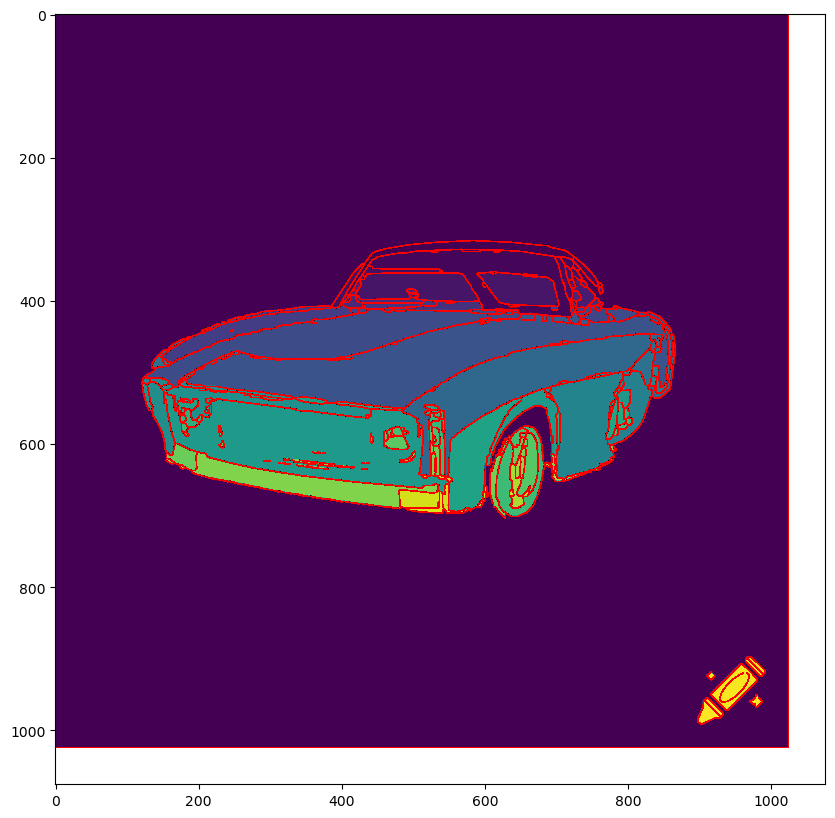

In [17]:
show_vertices_for_pathlist(unique_paths, segmentation)
# Closed paths here appear non-closed; they are still classified as closed, though, so OK

In [18]:
# For a list of unique paths, adjust the vertices so they snap together - SPEED UP POSSIBLE (fast already)
def snap_vertices(unique_paths):
    # Initialize dictionaries
    start_pts = {}
    end_pts = {}
    unique_pts = []

    # Populate them with path info
    for path in unique_paths:
        if not path.cyclic:
            if (path.pt[0].x, path.pt[0].y) in start_pts:
                start_pts[(path.pt[0].x, path.pt[0].y)].append(path)
            else:
                start_pts[(path.pt[0].x, path.pt[0].y)] = [path]
                if (path.pt[0].x, path.pt[0].y) not in unique_pts:
                    unique_pts.append((path.pt[0].x, path.pt[0].y))
            if (path.pt[-1].x, path.pt[-1].y) in end_pts:
                end_pts[(path.pt[-1].x, path.pt[-1].y)].append(path)
            else:
                end_pts[(path.pt[-1].x, path.pt[-1].y)] = [path]
                if (path.pt[-1].x, path.pt[-1].y) not in unique_pts:
                    unique_pts.append((path.pt[-1].x, path.pt[-1].y))

    # Loop through all unique points - for each get the paths, vertices, take the average
    for pt in unique_pts:
        tot_x = 0
        tot_y = 0
        ct = 0
        for path in start_pts[pt]:
            tot_x += path._curve.segments[0].vertex.x
            tot_y += path._curve.segments[0].vertex.y
            ct += 1
        for path in end_pts[pt]:
            tot_x += path._curve.segments[-1].vertex.x
            tot_y += path._curve.segments[-1].vertex.y
            ct += 1
        avg_x, avg_y = tot_x / ct, tot_y / ct
        for path in start_pts[pt]:
            path._curve.segments[0].vertex = _Point(avg_x, avg_y)
        for path in end_pts[pt]:
            path._curve.segments[-1].vertex = _Point(avg_x, avg_y)

    return start_pts, end_pts, unique_pts

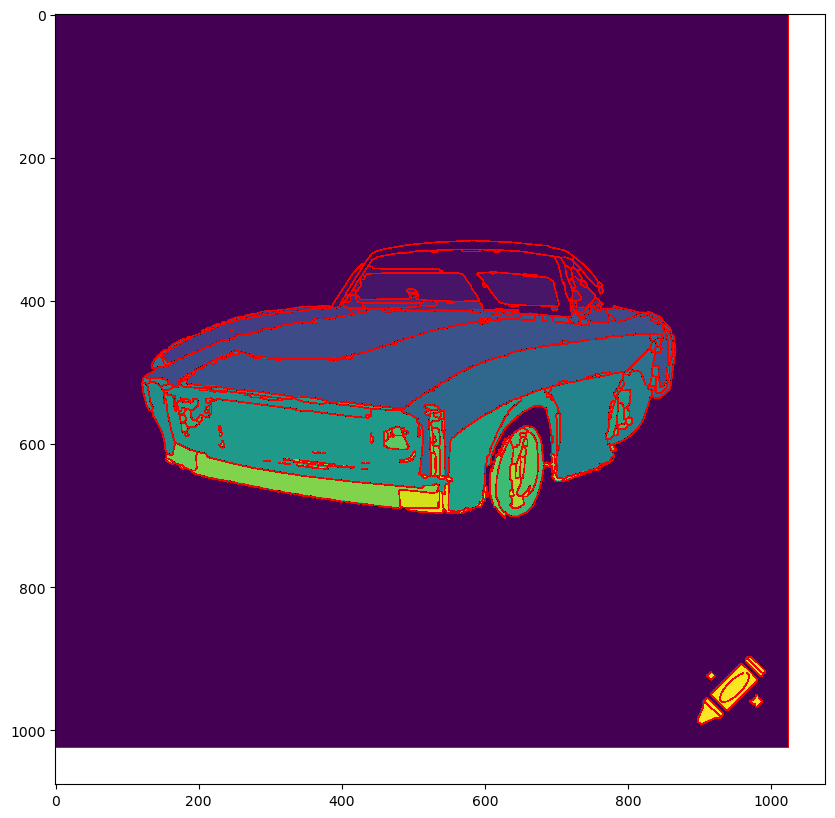

In [19]:
start_pts, end_pts, unique_pts = snap_vertices(unique_paths)
show_vertices_for_pathlist(unique_paths, segmentation)

Below this cell, we have various testing mechanics that are not related to the overall workflow.

[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 31]


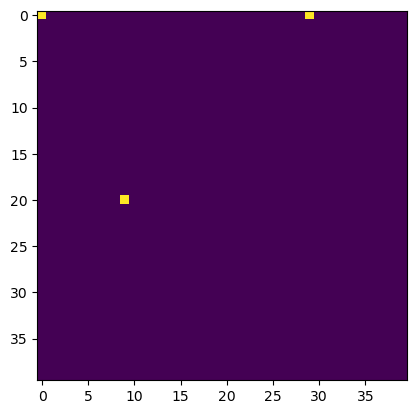

In [20]:
# Given an arbitrary list of points, calculate the optimal polygon for that path
points = []
for i in range(30):
    points.append((0, i))

for i in range(20):
    cur_x, cur_y = points[-1][0], points[-1][1]
    points.append((cur_x + 1, cur_y))
    points.append((cur_x + 1, cur_y - 1))

def path_from_pts(points, cyclic = False) -> _Path:
    pt = []
    for point in points:
        x, y = point
        pt.append(_Point(x, y))
    area = None
    region = -1
    path = _Path(pt, area, region)
    path.cyclic = cyclic
    return path

testpath = path_from_pts(points)
display_path(testpath, 40)

_calc_sums(testpath)
_calc_lon(testpath)
print(testpath._lon)
_bestpolygon(testpath)
display_polygon(testpath, 40)

In [21]:
_adjust_vertices(testpath)

0

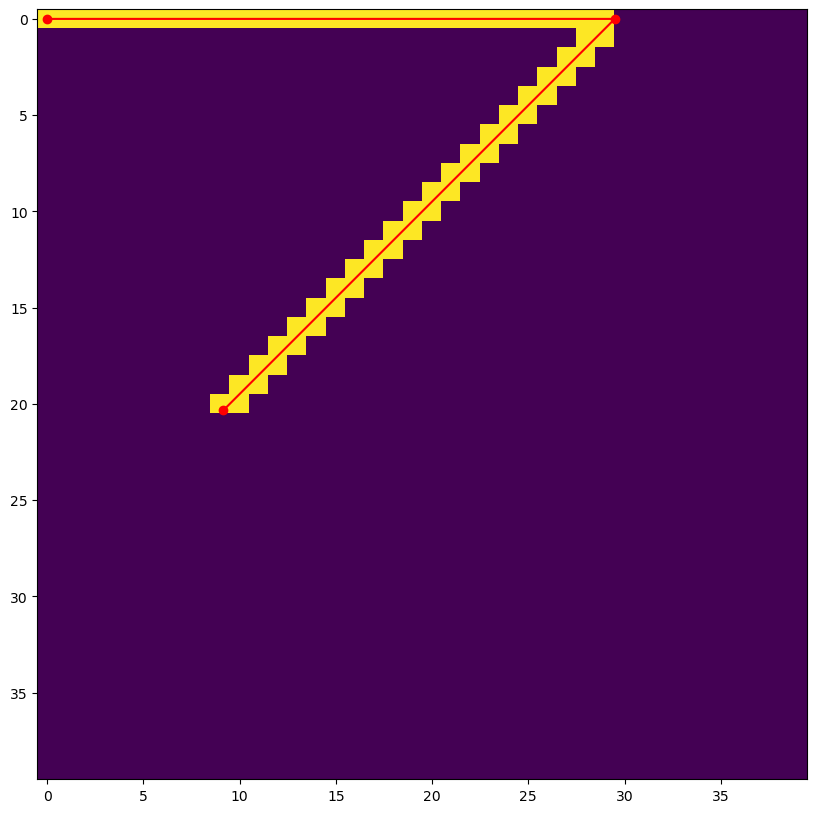

In [22]:
x = []
y = []
for segment in testpath._curve.segments:
    y.append(segment.vertex.x)
    x.append(segment.vertex.y)

plt.figure(figsize=(10, 10))

path_arr = np.zeros((40, 40))
for point in testpath.pt:
    path_arr[point.x, point.y] = 1
plt.imshow(path_arr)

plt.plot(x, y, marker='o', color='red', linestyle='-')
plt.show()

The start and end points for different paths that should have the same start and end points will drift off during this step -- they will no longer align. To fix this, after this step, for each point where it is the endpoint of more than one segment, we can simply set all instances of the point equal to its average position among all segments - this should do the trick, and will maintain snapping in the vertex adjustment portion of the algorithm

TO DO:
- Move into curve smoothing part of the algorithm - 
- How does path smoothing work? How much is local vs global?
- Important: How to deal with the path ends? Some may be corners, some may not be - 
- Can either make all be corners, or can merge paths (make a segments between), then process this for all 3-4
- And then take some kind of average of the results to see if it is a sharp corner or what shape it is, etc
